In [99]:
import os
import sys

AeroBDSM_OOP_dir = os.path.abspath(os.path.join('../AERO_LIB/'))
if AeroBDSM_OOP_dir not in sys.path:
    sys.path.append(AeroBDSM_OOP_dir)

PyXfoil_dir = os.path.abspath(os.path.join('../mpyXfoil/'))
if PyXfoil_dir not in sys.path:
    sys.path.append(PyXfoil_dir)

import pyXfoil as pxf
from isolated_plane import *
from libs.Atmosphere import atmo
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from pandas import DataFrame, read_excel
%config InlineBackend.figure_format = 'svg'

# Задание формата шрифта для графиков
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

import warnings
warnings.filterwarnings("ignore")

In [100]:
# Геометрические параметры несущей поверхности

# Параметры крыла
l_kr = 2.5            # размах крыла [м]
l_c = 2.5/2             # длина одной консоли [м]
b_b = 0.5             # бортовая хорда [м]
b_1 = 0.5             # концевая хорда [м]
chi_0 = radians(0)  # угол стреловидности по передней кромке [рад]
chi_1 = radians(0)      # угол стреловидности по задней кромке [рад]

# Параметры профиля крыла
cc_b = 0.12            # относительная толщина профиля бортовой хорды [-]
cc_1 = 0.12            # относительная толщина профиля концевой хорды [-]
cc = (cc_b + cc_1) / 2  # средняя относительная толщина профиля [-]
xx_c = 0.3              # относительная координата положения максимальной толщины [-]
hb = 1e-3               # относительная высота бугорков профиля [-]
rr_0 = 1                # относительный радиус скругления передней кромки [-]
aa = 0.5                # отношение геометрического параметра профиля `a` в долях рассматриваемой хорды [-]

xx_0 = 0                # относительная координата центра вращения в долях САХ (от носка САХ) относительно которой считаются моменты
xx_t = None             # относительная координата перехода пограничного слоя из ламинарного в турбулентный в долях рассматриваемой хорды
T_s = None              # средняя температура поверхности крыла, К

# Расчет геометрических параметров

S_kr = (b_b + b_1) / 2 * l_kr
lambda_kr = l_kr ** 2 / S_kr
zeta_kr = b_1 / b_b
chi_05 = atan(tan(chi_0) - 2 / lambda_kr * (1 / zeta_kr - 1) / (1 / zeta_kr + 1))

In [101]:
def c_x(X, q, S):
    return X / q / S

def c_y(Y, q, S):
    return Y / q / S

def m_z(M_z, q, S, L):
    return M_z / q / S / L

def m_x(M_x, q, S, L):
    return M_x / q / S / L

def c_y_to_c_ya(alpha, cy, cx):
    return cy * np.cos(np.deg2rad(alpha)) - cx * np.sin(np.deg2rad(alpha))

def c_x_to_c_xa(alpha, cy, cx):
    return cy * np.sin(np.deg2rad(alpha)) + cx * np.cos(np.deg2rad(alpha))

# Функции из Фролова
def get_c_ya_alpha_rect(lambd, c_y_a_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_y_a_alpha_profile) / (1 + c_y_a_alpha_profile*0.375/lambd)

    return c_y_a_alpha

def get_c_ya_alpha_profile_rect(lambd, c_y_a_alpha):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для профиля прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            c_y_a_alpha: float - производная коэффициена c_y_a прямоугольного крыла по углу атаки
    Вывод:  c_y_a_alpha_profile: float - производной коэффициента c_y_a по углу атаки профиля прямоугольного крыла, 1/рад
    '''
    c_y_a_alpha_profile = c_y_a_alpha / (1 - c_y_a_alpha * 0.375 / lambd)
    return c_y_a_alpha_profile

def get_c_ya_alpha_rect_eta(lambd, z, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для прямоугольного крыла
    
    Ввод:   lambd: float - удлинение крыла
            z: float - обратное сужение крыла (z = 1/eta = 1/(b_0/b_k))
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    k = 0.995 # Поправочный коэффициент, учит. сужение крыла для 0,2 < z < 1,0
    E = 1 + 2*z / lambd / (1 + z) # Поправка Джонса, учитывает фактоор скорости по кромке, равна отношению периметра в плане к размаху

    c_ya_alpha = k * c_ya_alpha_profile / (E + c_ya_alpha_profile / np.pi / lambd)
    return c_ya_alpha

def get_c_ya_alpha_chi(lambd, chi_05, c_ya_alpha_profile):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла со стреловидностью
    
    Ввод:   lambd: float - удлинение крыла
            chi_05: float - угол стреловидности по линии средин хорд, рад
            c_ya_alpha_profile: float - производная коэффициена c_y_a профиля по углу атаки
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для прямоугольного крыла, 1/рад
    '''

    c_y_a_alpha = (c_ya_alpha_profile * np.cos(chi_05)) / (1 + (c_ya_alpha_profile * np.cos(chi_05)) / np.pi / lambd)

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons_low_lambda(lambd):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1) по формуле Джонса
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''

    c_y_a_alpha = np.pi * lambd / 2

    return c_y_a_alpha

def get_c_ya_alpha_Dzhons(lambd, chi_pk, chi_zk, z):
    '''
    Расчет производной коэффициента c_y_a по углу атаки для крыла малого удлинения (lambda<1)
    
    Ввод:   lambd: float - удлинение крыла
            
    Вывод:  c_y_alpha: float - производной коэффициента c_y_a по углу атаки для крыла малого удлинения, 1/рад
    '''
    eta = 1 / z # сужение крыла
    # Отношение полупериметра крыла к его размаху для трапециевидных крыльев
    pp = 1/2 * (1/np.cos(chi_pk) + 1/np.cos(chi_zk)) * (2 / lambd / (eta + 1))

    c_y_a_alpha = 2 * np.pi * lambd / (pp * lambd + 2)

    return c_y_a_alpha

def get_c_xa_i(lambd, z, chi_025, c_y_a):
    '''
    Расчет коэффициента индуктивного сопротивления крыла

    Ввод: 
        lambd: float - удлинение крыла
        z: float - облатное сужение крыла
        chi_025: float - угол стреловидности по линии 1/4 хорд, рад
        c_y_a: float - коэффициент подъемной силы крыла
    Вывод:
        c_xa_i: float - коэффициент индуктивного сопротивления
    '''
    eta = 1 / z # сужение крыла
    delta = 0.002 * lambd / np.cos(chi_025) * (3.1 - 14/eta + 20/eta/eta - 8/eta/eta/eta)

    lambd_eff = lambd / (1 + delta) # эффективное удлинение крыла
    c_xa_i = c_y_a ** 2 / np.pi / lambd_eff

    return c_xa_i

def get_c_y_a_alpha(alphas, c_y_a):
    """
    Расчет производной по углу атаки коэффициента c_y_a

    Ввод:
        alphas: np.array - массив углов атаки, град
        c_y_a: np.array - массив коэффициентов подъемной силы c_y_a
    Вывод:
        c_y_a_alpha: float - производная коэффициента подъменой силы c_y_a, 1/рад
    """
    c_y_a_alpha = (c_y_a[2] - c_y_a[0]) / (alphas[2] - alphas[0])
    return c_y_a_alpha

In [102]:
# Результаты расчета в Ansys

alpha_Ansys = np.array([0, 2, 4, 8, 12, 16])

cxa_Ansys = np.array([0.01024871, 0.01169752, 0.01607037, 0.03400446, 0.06367909, 0.16330742])
cya_Ansys = np.array([1.06787254e-04, 1.37893522e-01, 2.76604566e-01, 5.51021198e-01, 7.88472609e-01, 6.76273519e-01])
mza_Ansys = np.array([3.37402638e-05, 1.52577015e-02, 3.08446023e-02, 6.22609739e-02, 8.85198277e-02, 1.05769155e-01])
# Параметры невозмущенного потока
H_Ansys = 0                         # Высота полета
rho_Ansys = atmo.rho(H_Ansys)       # Плотность воздуха
a_Ansys = atmo.a(H_Ansys)           # Скорость звука
nu_Ansys = 15.06e-6                 # Кинематическая вязкость воздуха

# M = 0.2                             # Число Маха
V = 68                    # Скорость потока
M = V / a_Ansys
q = rho_Ansys * V ** 2 / 2          # Скоростной напор

Re_Ansys = V * b_b / nu_Ansys       # Число Рейнольдса для крыла

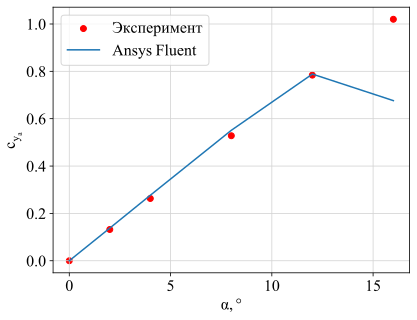

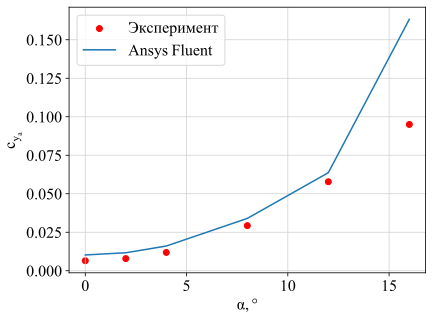

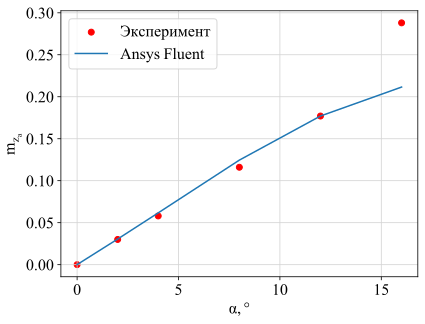

In [103]:
# Результаты эксперимента ЦАГИ, Атлас 1940
alpha_EXP = np.array([0, 2, 4, 8, 12, 16])

cya_EXP = np.array([0.000, 0.132, 0.263, 0.528, 0.784, 1.020])
cxa_EXP = np.array([0.0065, 0.0079, 0.0119, 0.0293, 0.0578, 0.0950])
mza_EXP = np.array([0.000, 0.030, 0.058, 0.116, 0.177, 0.288])

# Сравнение ANSYS с экспериментом
plt.scatter(alpha_EXP, cya_EXP, label = '$Эксперимент$', color = 'red')
plt.plot(alpha_Ansys, cya_Ansys, label = '$Ansys\;Fluent$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')

plt.show()

# Сравнение ANSYS с экспериментом
plt.scatter(alpha_EXP, cxa_EXP, label = '$Эксперимент$', color = 'red')
plt.plot(alpha_Ansys, cxa_Ansys, label = '$Ansys\;Fluent$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$c_{y_a}$')

plt.show()

# Сравнение ANSYS с экспериментом
plt.scatter(alpha_EXP, mza_EXP, label = '$Эксперимент$', color = 'red')
plt.plot(alpha_Ansys, mza_Ansys/0.5, label = '$Ansys\;Fluent$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.xlabel('$\\alpha, \degree$')
plt.ylabel('$m_{z_a}$')

plt.show()

In [104]:
Airfoil = SubsonicProfile(b_b, cc, xx_c, rr_0, hb, 'naca')      # Создание экземпляра класса дозвукового профиля
IP = IsolatedPlane(S_kr, lambda_kr, zeta_kr, chi_05, Airfoil)   # Создание экземпляра класса изолированного крыла

In [105]:
# Расчет крыла по Лебедеву-Чернобровкину

cya_LiCH, cxa_LiCH, mza_LiCH = [], [], []

alphas = np.linspace(0, 20, 31)

for alf in alphas:
    cxa_LiCH.append(IP.c_xa(M, np.deg2rad(alf)))
    cya_LiCH.append(IP.c_ya(M, np.deg2rad(alf)))

In [106]:
# Расчет АДХ профиля крыла по Xfoil
S = pxf.Session()
EXP = pxf.Experiment()

AIRFOIL = 'NACA0012'        # Имя профиля (имя профиля или файл с координатами профиля)
Re = Re_Ansys               # Число Рейнольдса
ITER = 70                 # Число итераций
INIT_TYPE_ADX = 'alpha'     # Инициализация расчета (по c_ya или alpha)
value_min = -0.1               # Значение c_ya или alpha
value_max = 18
inc = 2

Res_ADX = S.get_ADX(AIRFOIL, Re, INIT_TYPE_ADX, value_min, value_max, inc, ITER)
alpha_airfoil, c_ya_airfoil, c_xa_airfoil = Res_ADX['alpha'], Res_ADX['c_ya'], Res_ADX['c_xa']

In [107]:
# Расчет производных коэффициента c_y_a по углу атаки alpha
c_y_a_alpha_Xfoil = (c_ya_airfoil[1] - c_ya_airfoil[0]) / (alpha_airfoil[1] / 57.3 - alpha_airfoil[0] / 57.3)
# c_y_a_alpha_Xfoil = get_c_y_a_alpha(alpha_airfoil, c_ya_airfoil)        # Производная c_y_a_alpha из Xfoil
c_y_a_alpha_1 = get_c_ya_alpha_rect(lambda_kr, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_2 = get_c_ya_alpha_rect_eta(lambda_kr, 1, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_3 = get_c_ya_alpha_chi(lambda_kr, chi_05, c_y_a_alpha_Xfoil) / 57.3
c_y_a_alpha_4 = get_c_ya_alpha_Dzhons_low_lambda(lambda_kr) / 57.3
c_y_a_alpha_5 = get_c_ya_alpha_Dzhons(lambda_kr, chi_0, chi_1, 1) / 57.3

delta_c_ya = c_ya_airfoil[0] / (1 + c_y_a_alpha_Xfoil * 0.375 / lambda_kr) * 0

In [108]:
# Производная крыла
(cya_Ansys[1] - cya_Ansys[0]) / (alpha_Ansys[1] / 57.3 - alpha_Ansys[0] / 57.3)
# c_y_a_alpha_Xfoil

3.9475899504728993

In [109]:
def get_alpha_kr(M):
        alpha_kr_array = np.array([[0, 13.04233502],
        [0.0625, 12.88640565],
        [0.125, 12.82261655],
        [0.1875, 12.81552876],
        [0.25, 12.85805499],
        [0.3125, 13.00689657],
        [0.375, 13.22661554],
        [0.4375, 13.51012311],
        [0.5, 13.89994652],
        [0.5625, 14.38899798],
        [0.625, 14.99180071],
        [0.6875, 15.70730979],
        [0.75, 16.62871039],
        [0.8125, 17.72021594],
        [0.875, 19.08814178],
        [0.9375, 20.61199697],
        [1, 22.19964178],
        [1.0625, 23.85816297],
        [1.125, 25.51668416],
        [1.1875, 27.06180272],
        [1.25, 28.55021948],
        [1.3125, 30.10242533],
        [1.375, 31.62628052],
        [1.4375, 33.14304793],
        [1.46875, 34.05027346]])
        akr = interp1d(alpha_kr_array[:,0], alpha_kr_array[:,1])
        return float(akr(M))
alpha_kr = get_alpha_kr(M)-1

alpha_cya = np.linspace(0, alpha_kr, 20)

def polinome(x):
        return (-2.636e-05*x**4 + 0.008567*x**3 - 0.1611*x**2 + 0.3011*x - 0.) * 0.04

x = np.linspace(0, 5, 21)

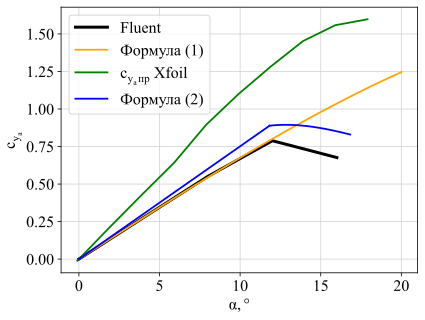

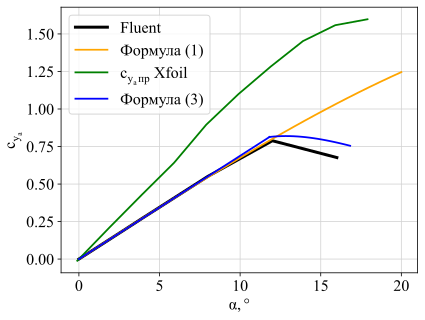

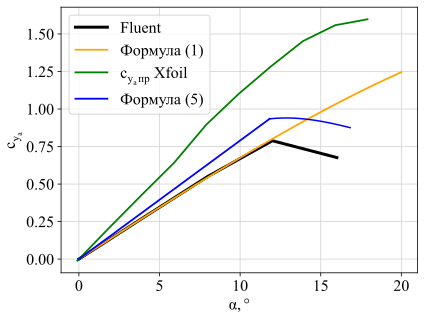

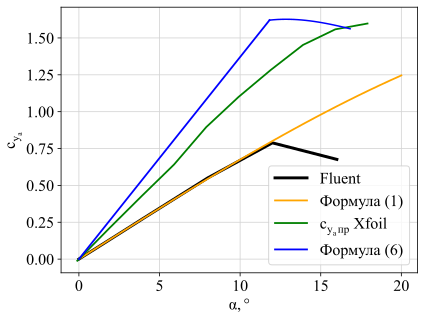

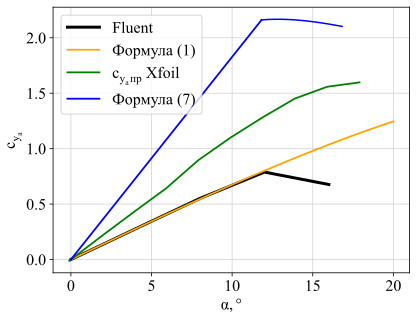

In [110]:
# Визуализация АДХ профиля крыла

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_1 + delta_c_ya, lw = 1.8, color = 'blue')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_1 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_2 + delta_c_ya, lw = 1.8, color = 'blue')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_2 + delta_c_ya, label = 'Формула (3)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_3 + delta_c_ya, color = 'blue')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_3 + delta_c_ya, label = 'Формула (5)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_4 + delta_c_ya, color = 'blue')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_4 + delta_c_ya, label = 'Формула (6)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

plt.plot(alpha_Ansys, cya_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alphas, cya_LiCH, label = 'Формула (1)', lw = 1.8, color = 'orange')
plt.plot(alpha_airfoil, c_ya_airfoil, label = '$c_{y_a}{_{пр}}\;Xfoil$', lw = 1.8, color = 'green')
plt.plot(x+alpha_kr, polinome(x) + alpha_kr * c_y_a_alpha_5 + delta_c_ya, color = 'blue')
plt.plot(alpha_cya, alpha_cya * c_y_a_alpha_5 + delta_c_ya, label = 'Формула (7)', lw = 1.8, color = 'blue')
plt.ylabel('$c_{y_a}$')
plt.xlabel('$\\alpha, \degree$')
plt.grid(color = 'lightgray')
plt.legend(loc = 'best')
plt.show()

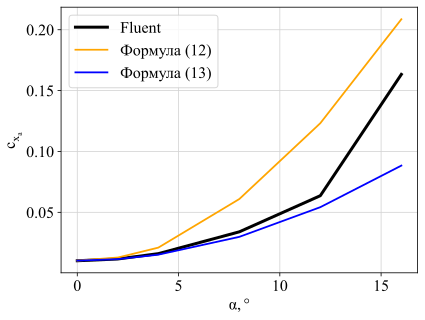

In [111]:
cxa0_LiCH = []
cxa_prof_LiCH = []
cxa_LiCH = []
for alf in alpha_Ansys:
    cxa0_LiCH.append(IP.c_xa0(M, 0.9))
    cxa_prof_LiCH.append(IP.c_xa_pr(M))
    cxa_LiCH.append(IP.c_xa(M, np.deg2rad(alf)))

# Сопротивление крыла
cxai = get_c_xa_i(lambda_kr, 1, np.deg2rad(0), alpha_Ansys * c_y_a_alpha_2 + delta_c_ya)

plt.plot(alpha_Ansys, cxa_Ansys, label = 'Fluent', lw = 3, color = 'black')
plt.plot(alpha_Ansys, cxa_LiCH, label = 'Формула (12)', lw = 1.8, color = 'orange')
plt.plot(alpha_Ansys, (cxai + cxa_prof_LiCH), label = 'Формула (13)', lw = 1.8, color = 'blue')
plt.legend(loc = 'best')
plt.grid(color = 'lightgray')
plt.ylabel('$c_{x_a}$')
plt.xlabel('$\\alpha, \degree$');

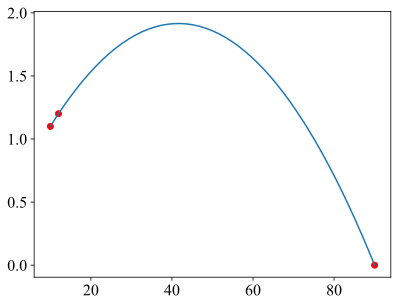

In [112]:
# Получение уравнения параболы
import sympy as sp
from sympy.solvers.solveset import linsolve


def get_parab(xx, alpha1, cya1, alpha_kr, cya_max):
    a, b, c = sp.symbols("a b c")

    eq1 = sp.Eq(alpha1**2 * a + alpha1 * b + c, cya1)
    eq2 = sp.Eq(alpha_kr**2 * a + alpha_kr * b + c, cya_max)
    eq3 = sp.Eq(90**2 * a + 90 * b + c, 0)
    # eq2 = sp.Eq(2 * alpha_kr * a + b + 0, cya_max)

    eqs = [eq1, eq2, eq3]
    res = linsolve(eqs, (a, b, c))
    aa = float(res.args[0][0])
    bb = float(res.args[0][1])
    cc = float(res.args[0][2])
    return aa * xx**2 + bb * xx + cc
xx = np.linspace(10, 90, 51)
plt.plot(xx, get_parab(xx, 10, 1.1, 12, 1.2))
plt.scatter([10, 12, 90], [1.1, 1.2, 0], color = 'red')

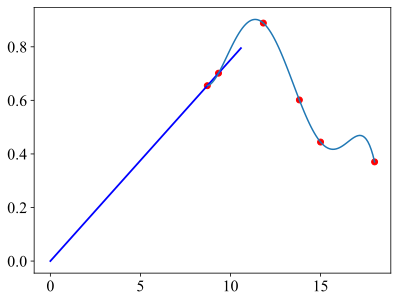

In [113]:
x1 = alpha_cya[:-5][-1]
x2 = alpha_cya[:-4][-1]
x3 = alpha_kr
x4 = alpha_kr + 2
x5 = 15
x6 = 18
x7 = 20

y1 = x1 * c_y_a_alpha_1 + delta_c_ya
y2 = x2 * c_y_a_alpha_1 + delta_c_ya
y3 = x3 * c_y_a_alpha_1
y4 = x2 * c_y_a_alpha_1 + delta_c_ya - 0.1
# y5 = alpha_kr * c_y_a_alpha_1 + delta_c_ya - 0.5
y5 = c_y_a_alpha_1 * alpha_kr / 2
y6 = c_y_a_alpha_1 * alpha_kr / 2 / 1.2

x = np.array([x1, x2, x3, x4, x5, x6])
y = np.array([y1, y2, y3, y4, y5, y6])
t = np.polyfit(x,y, 6)
f = np.poly1d(t)

# def polinome(x):
#         # return -2.636e-05*x**4 + 0.008567*x**3 - 0.1611*x**2 + 0.3011*x - 0.1487
#         return -0.0008173 * x**2 + 0.06798 * x + 0.5019

# plt.plot(x,y)
# x=np.array([12, 13, 14, 15])
xx = np.linspace(x1, x6, 101)
# plt.plot(x+(alpha_kr-1), c_y_a_alpha_2*(alpha_kr-1)*1.01 + polinome(x)*0.04 + delta_c_ya, ls = '--', color = 'red')
# plt.plot(x, c_y_a_alpha_2*(alpha_kr) + polinome(x) + delta_c_ya, ls = '--', color = 'red')
# plt.plot((alpha_cya-1), (alpha_cya-1) * c_y_a_alpha_2 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')
# plt.plot(alpha_Ansys, cya_Ansys, label = 'Ansys', lw = 1.8, color = 'red')
plt.plot(alpha_cya[:-2], alpha_cya[:-2] * c_y_a_alpha_1 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')
plt.plot(xx, f(xx))
plt.scatter(x, y, color = 'red')

In [114]:
import sympy as sp
from sympy.solvers.solveset import linsolve

# plt.plot(alpha_cya[:-4], alpha_cya[:-4] * c_y_a_alpha_1 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')

# xx1 = alpha_cya[:-4][-1]
# yy1 = alpha_cya[:-4][-1] * c_y_a_alpha_1 + delta_c_ya

# xx2 = alpha_kr
# yy2 = alpha_kr * c_y_a_alpha_1 + delta_c_ya

# xx3 = alpha_kr + alpha_kr - alpha_cya[:-3][-1]
# yy3 = alpha_cya[:-3][-1] * c_y_a_alpha_1 + delta_c_ya

# x = np.array([xx1, xx2, xx3])
# y = np.array([yy1, yy2, yy3])

# a, b, c = sp.symbols("a b c")

# eq1 = sp.Eq(xx1**2 * a + xx1 * b + c, yy1)
# eq2 = sp.Eq(xx2**2 * a + xx2 * b + c, yy2)
# eq3 = sp.Eq(xx3**2 * a + xx3 * b + c, yy3)
# # eq2 = sp.Eq(2 * alpha_kr * a + b + 0, cya_max)

# eqs = [eq1, eq2, eq3]
# res = linsolve(eqs, (a, b, c))
# aa = float(res.args[0][0])
# bb = float(res.args[0][1])
# cc = float(res.args[0][2])

# # def parab(x):
# #     return aa * x**2 + bb * x + cc

# t = np.polyfit(x,y, 4)
# f = np.poly1d(t)

# xx = np.linspace(xx1, xx3, 51)
# plt.plot(xx, f(xx))
# plt.scatter(x, y, color = 'red')

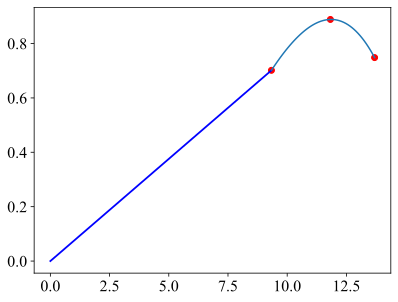

In [115]:
plt.plot(alpha_cya[:-4], alpha_cya[:-4] * c_y_a_alpha_1 + delta_c_ya, label = 'Формула (2)', lw = 1.8, color = 'blue')

xx1 = alpha_cya[:-4][-1]
yy1 = alpha_cya[:-4][-1] * c_y_a_alpha_1 + delta_c_ya

xx2 = alpha_kr
yy2 = alpha_kr * c_y_a_alpha_1 + delta_c_ya

xx3 = alpha_kr + alpha_kr - alpha_cya[:-3][-1]
yy3 = alpha_cya[:-3][-1] * c_y_a_alpha_1 + delta_c_ya

x = np.array([xx1, xx2, xx3])
y = np.array([yy1, yy2, yy3])

a, b, c = sp.symbols("a b c")

eq1 = sp.Eq(xx1**2 * a + xx1 * b + c, yy1)
eq2 = sp.Eq(xx2**2 * a + xx2 * b + c, yy2)
eq3 = sp.Eq(xx3**2 * a + xx3 * b + c, yy3)
# eq2 = sp.Eq(2 * alpha_kr * a + b + 0, cya_max)

eqs = [eq1, eq2, eq3]
res = linsolve(eqs, (a, b, c))
aa = float(res.args[0][0])
bb = float(res.args[0][1])
cc = float(res.args[0][2])

# def parab(x):
#     return aa * x**2 + bb * x + cc

t = np.polyfit(x,y, 4)
f = np.poly1d(t)

xx = np.linspace(xx1, xx3, 51)
plt.plot(xx, f(xx))
plt.scatter(x, y, color = 'red')

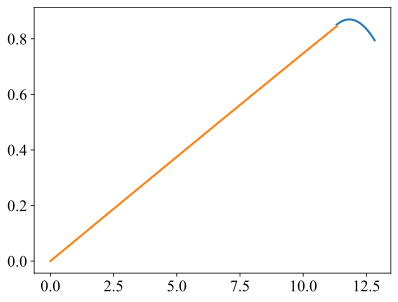

In [130]:
n = 0.5
x_left = alpha_kr - n
cya_max = alpha_kr * c_y_a_alpha_1

A = - c_y_a_alpha_1 / (2*alpha_kr - 2*x_left)
B = c_y_a_alpha_1 * alpha_kr / (alpha_kr - x_left)
C = - (c_y_a_alpha_1 * x_left**2) / (2*alpha_kr - 2*x_left)

# A = c_y_a_alpha_1 / (2 * x_left - 2 * alpha_kr)
# B = -2 * A * alpha_kr
# C = (cya_max + A**2 * alpha_kr**2) / A

def parab(x):
    return A*x**2 + B*x + C

# def test(x):
#     return np.sqrt(2 * (x_left * c_y_a_alpha_1 - cya_max) * (x - x_left)) + cya_max

xx = np.linspace(alpha_kr-n, alpha_kr+1, 21)
alpha_n = np.linspace(0, x_left, 21)
plt.plot(xx, parab(xx), lw = 2)
plt.plot(alpha_n, np.sin(np.deg2rad(alpha_n))*57.3 * c_y_a_alpha_1, lw = 2)
# plt.scatter(alpha_kr, alpha_kr * c_y_a_alpha_1)